# Driver State Detection

## Setup

In [ ]:
# a Python package for tracking the carbon emissions produced by various
# kinds of computer programs, from straightforward algorithms to deep neural networks.
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 20.5 MB/s 
     |████████████████████████████████| 46 kB 969 kB/s 
     |████████████████████████████████| 66 kB 1.2 MB/s 


## Import libraries

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import datasets ,layers,models
import matplotlib.pyplot as plt
from keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications import *

from tensorflow.keras.utils import to_categorical
import numpy as np 
import pandas as pd
import plotly.express as px
import os 
import cv2
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import Sequence

from codecarbon import EmissionsTracker

from keras.utils import data_utils
import matplotlib.image as mpimg
from keras.layers.core import Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D,GlobalAveragePooling2D

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

path_to_zip_file = '/content/drive/MyDrive/Estrutura de dados II/state-farm-distracted-driver-detection.zip'
directory_to_extract_to = './'

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

## Config paths

In [ ]:
DATA_DIR = "./state-farm-distracted-driver-detection/imgs"
TEST_DIR = os.path.join(DATA_DIR,"test")
TRAIN_DIR = os.path.join(DATA_DIR,"train")
MODEL_PATH = os.path.join(os.getcwd(),"model","self_trained")
PICKLE_DIR = os.path.join(os.getcwd(),"pickle_files")
CSV_DIR = os.path.join(os.getcwd(),"csv_files")

In [ ]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
if not os.path.exists(PICKLE_DIR):
    os.makedirs(PICKLE_DIR)
if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)

Model path does not exists
Model path created


## Import dataset

In [ ]:
file_name = './state-farm-distracted-driver-detection/driver_imgs_list.csv' 
df = pd.read_csv(file_name)
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


## Exploratory Data Analysis

In [ ]:
fig1 = px.histogram(df, x="classname", color="classname", title="Number of images by categories ")

# show the figure
fig1.show()

In [ ]:
# Find the frequency of images per driver
drivers_id = pd.DataFrame((df['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
fig2 = px.histogram(drivers_id, x="driver_id",y="Counts" ,color="driver_id", title="Number of images by subjects ")

# show the figure
fig2.show()

In [ ]:
fig3 = px.histogram(df, x="subject", color="classname", title="Number of images by driver and categories ")

# show the figure
fig3.show()

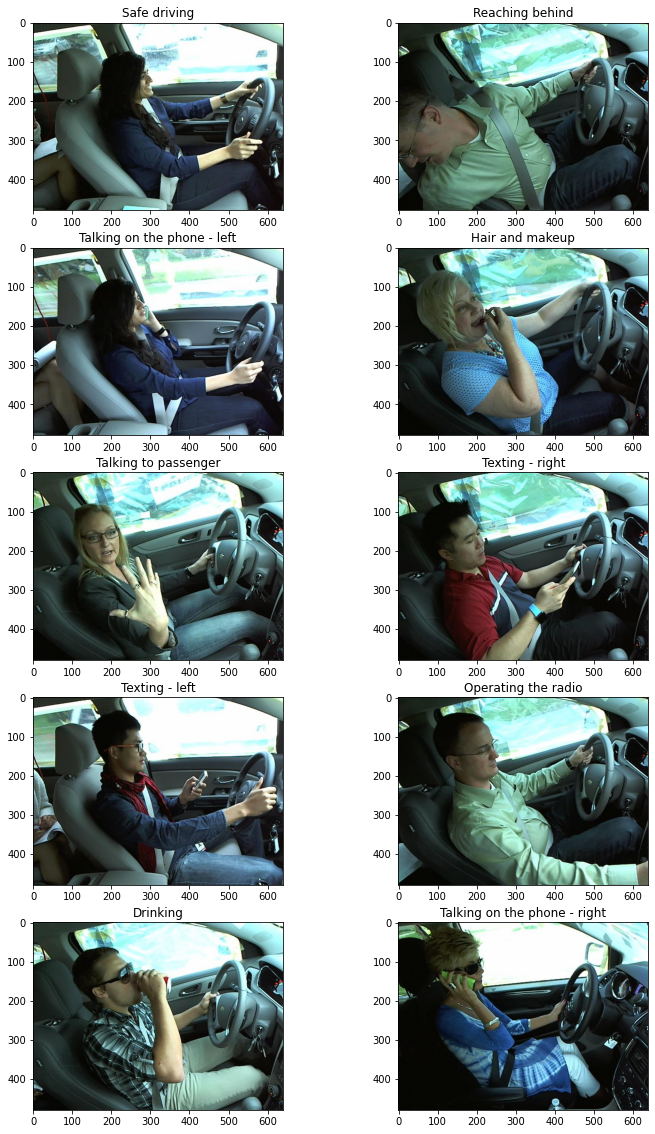

In [ ]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}


plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = './state-farm-distracted-driver-detection/imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

In [ ]:
print(df['subject'].nunique())
print(df['classname'].nunique())

26
10


## Data Preparation

In [ ]:
def create_csv(DATA_DIR,filename):
    class_names = os.listdir(DATA_DIR)
    data = list()
    if(os.path.isdir(os.path.join(DATA_DIR,class_names[0]))):
        for class_name in class_names:
            file_names = os.listdir(os.path.join(DATA_DIR,class_name))
            for file in file_names:
                data.append({
                    "Filename":os.path.join(DATA_DIR,class_name,file),
                    "ClassName":class_name
                })
    else:
        class_name = "test"
        file_names = os.listdir(DATA_DIR)
        for file in file_names:
            data.append(({
                "FileName":os.path.join(DATA_DIR,file),
                "ClassName":class_name
            }))
    data = pd.DataFrame(data)
    data.to_csv(os.path.join(os.getcwd(),"csv_files",filename),index=False)

create_csv(TRAIN_DIR,"train.csv")
create_csv(TEST_DIR,"test.csv")
data_train = pd.read_csv(os.path.join(os.getcwd(),"csv_files","train.csv"))
data_test = pd.read_csv(os.path.join(os.getcwd(),"csv_files","test.csv"))

Converting into numerical values

In [ ]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:int(id) for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

{'c3': 0, 'c2': 1, 'c0': 2, 'c9': 3, 'c8': 4, 'c5': 5, 'c1': 6, 'c4': 7, 'c6': 8, 'c7': 9}


In [ ]:
data_train.shape[0]

22424

Splitting into Train and Test sets

In [ ]:
data_train = data_train.sample(frac=1)
size = data_train.shape[0]
df = data_train.copy()
df_train = df.iloc[:size - int(0.2*size)]
df_test = data_train.iloc[size - int(0.2*size):]

In [ ]:
size

22424

In [ ]:
df_test

,Filename,ClassName
7079,./state-farm-distracted-driver-detection/imgs/...,4
9202,./state-farm-distracted-driver-detection/imgs/...,3
8382,./state-farm-distracted-driver-detection/imgs/...,4
8473,./state-farm-distracted-driver-detection/imgs/...,4
1314,./state-farm-distracted-driver-detection/imgs/...,2
...,...,...
9776,./state-farm-distracted-driver-detection/imgs/...,3
3273,./state-farm-distracted-driver-detection/imgs/...,9
15322,./state-farm-distracted-driver-detection/imgs/...,0
13403,./state-farm-distracted-driver-detection/imgs/...,0


In [ ]:
df_test.shape

(4484, 2)

## Model preparation

In [ ]:
DIM = 256
NB_CHANNELS = 3
NB_CLASSES = 10

In [ ]:
def get_train_generator(df_train,df_test, image_dir = None, x_col = "Image_name", y_cols = "Plane", 
                        shuffle=True, batch_size=64, seed=1, target_w = 256, target_h = 256):
    ### Perform data augmentation here
    image_generator = ImageDataGenerator(rescale=1/255 ,rotation_range = 5, shear_range = 0.02,zoom_range = 0.02,
                                         samplewise_center=True, samplewise_std_normalization= True)
    
    ### Create the image generator

    train_generator=image_generator.flow_from_dataframe(
    dataframe=df_train,
    directory=None,
    x_col="Filename",
    y_col="ClassName",
    subset="training",
    batch_size=batch_size,
    seed=seed,
    shuffle=shuffle,
    class_mode="raw",
    target_size=(target_w,target_h))

    valid_generator=image_generator.flow_from_dataframe(
    dataframe=df_test,
    directory=None,
    x_col="Filename",
    y_col="ClassName",
    subset="training",
    batch_size=batch_size,
    seed=seed,
    shuffle=shuffle,
    class_mode="raw",
    target_size=(target_w,target_h))
    
    return train_generator, valid_generator

In [ ]:
data_test.head()

,FileName,ClassName
0,./state-farm-distracted-driver-detection/imgs/...,test
1,./state-farm-distracted-driver-detection/imgs/...,test
2,./state-farm-distracted-driver-detection/imgs/...,test
3,./state-farm-distracted-driver-detection/imgs/...,test
4,./state-farm-distracted-driver-detection/imgs/...,test


In [ ]:
data_train['ClassName'] = data_train['ClassName'].astype('int')

In [ ]:
type(int(data_train.ClassName.iloc[5]))

int

In [ ]:
train_generator, valid_generator = get_train_generator(df_train,df_test, image_dir = None, x_col = "Filename", y_cols = "ClassName", 
                        shuffle=True, batch_size=64, seed=1, target_w = 256, target_h = 256)

Found 17940 validated image filenames.
Found 4484 validated image filenames.


## Baseline model

This is our baseline model, we will only test it on this dat and see the performance and also if there is anything needs to be fixed, afther then, we will fine-tune a prai-trained model ( on ImageNet Data) on this data

In [ ]:
base_model = Sequential()
base_model.add(Conv2D(32, (3, 3), padding="same",input_shape = (DIM , DIM , NB_CHANNELS)))
base_model.add(Activation("relu"))
base_model.add(BatchNormalization(axis=1))
base_model.add(MaxPooling2D(pool_size=(3, 3)))
base_model.add(Conv2D(64, (3, 3), padding="same"))
base_model.add(Activation("relu"))
base_model.add(BatchNormalization(axis=1))
base_model.add(Conv2D(64, (3, 3), padding="same"))
base_model.add(Activation("relu"))
base_model.add(BatchNormalization(axis=1))
base_model.add(MaxPooling2D(pool_size=(2, 2)))
base_model.add(Conv2D(128, (3, 3), padding="same"))
base_model.add(Activation("relu"))
base_model.add(BatchNormalization(axis=1))
base_model.add(Conv2D(128, (3, 3), padding="same"))
base_model.add(Activation("relu"))
base_model.add(BatchNormalization(axis=1))
base_model.add(MaxPooling2D(pool_size=(2, 2)))
base_model.add(Flatten())
base_model.add(Dense(1024))
base_model.add(Activation("relu"))
base_model.add(BatchNormalization())
base_model.add(Dense(10))
base_model.add(Activation("softmax"))
base_model.build((0,256,256,3))
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     1024      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 85, 85, 64)        0

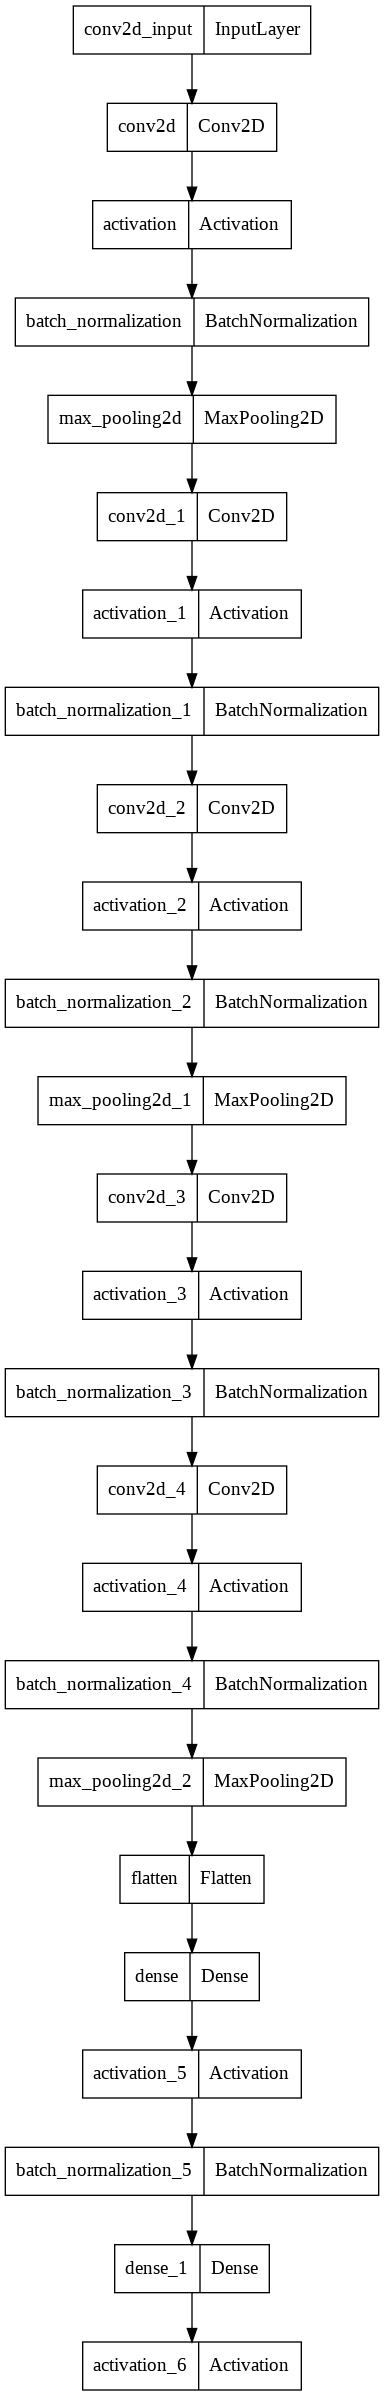

In [ ]:
tf.keras.utils.plot_model(
    base_model, to_file='./state-farm-distracted-driver-detection/imgs/baseline_model.png'
)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy',
                                            patience = 2,
                                            verbose=0,
                                            factor=0.1,
                                            min_lr=0.000001)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)


base_model.compile(optimizer = opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# train the network
print("[INFO] training network...")
history = base_model.fit(train_generator,validation_data = valid_generator, epochs = 7,callbacks=[learning_rate_reduction])

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

[INFO] training network...
Epoch 1/7
281/281 [==============================] - 440s 2s/step - loss: 0.3223 - accuracy: 0.9109 - val_loss: 0.9972 - val_accuracy: 0.6905 - lr: 1.0000e-04
Epoch 2/7
281/281 [==============================] - 423s 2s/step - loss: 0.0399 - accuracy: 0.9880 - val_loss: 0.0605 - val_accuracy: 0.9839 - lr: 1.0000e-04
Epoch 3/7
281/281 [==============================] - 420s 1s/step - loss: 0.0283 - accuracy: 0.9920 - val_loss: 0.1462 - val_accuracy: 0.9547 - lr: 1.0000e-04
Epoch 4/7
281/281 [==============================] - 417s 1s/step - loss: 0.0157 - accuracy: 0.9959 - val_loss: 0.0476 - val_accuracy: 0.9866 - lr: 1.0000e-04
Epoch 5/7
281/281 [==============================] - 413s 1s/step - loss: 0.0157 - accuracy: 0.9957 - val_loss: 0.0379 - val_accuracy: 0.9891 - lr: 1.0000e-04
Epoch 6/7
281/281 [==============================] - 416s 1s/step - loss: 0.0127 - accuracy: 0.9965 - val_loss: 0.0329 - val_accuracy: 0.9902 - lr: 1.0000e-04
Epoch 7/7
281/281 [

Plot The history of the training Process

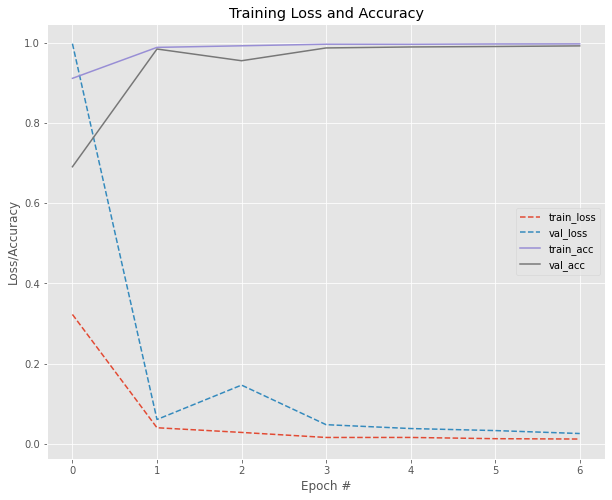

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 7), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 7), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 7), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 7), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [ ]:
# print code carbon results
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

[INFO] 0.07547938452986881 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.003919561951455499 kWh
[INFO] Energy consumed for all GPU: 0.03650870809606344 kWh
[INFO] Energy consumed for all CPU: 0.03505111448234984 kWh
[INFO] CO2 emission 0.047626220824339746(in Kg)


In [ ]:
# get the key from the value in labels_id
def get_key(val):
    for key, value in labels_id.items():
         if val == value:
             return key
 
    return

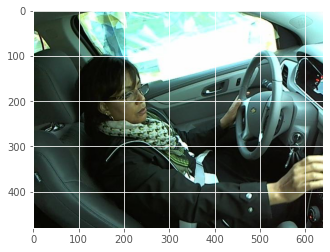

In [ ]:
image = mpimg.imread("./state-farm-distracted-driver-detection/imgs/test/img_1.jpg")
plt.imshow(image)

In [ ]:
img = cv2.resize(image, (256, 256)) 

img = img.reshape(1,256,256,3)
img.shape

(1, 256, 256, 3)

In [ ]:
ypred = base_model.predict(img/255)
print(ypred)
ypred_class = np.argmax(ypred,axis=1)
ypred_class

1/1 [==============================] - 0s 19ms/step
[[3.7585820e-14 9.6802906e-15 5.5825129e-22 2.3324090e-21 1.4118762e-18
  9.9999988e-01 9.2309601e-18 4.0969950e-18 2.9536509e-15 1.0444452e-07]]


array([5])

In [ ]:
c = get_key(ypred_class)
activity_map[c]

'Operating the radio'

As we can see, we have chosen a operating radio image and the model is predicting it.

In [ ]:
# save the model
base_model.save('./state-farm-distracted-driver-detection/model/baseline_model.h5')

## ResNet50

In [ ]:
encoder_resnet50 = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(DIM,DIM ,NB_CHANNELS)) 
new_model = Sequential(name = 'encoder_resnet_50')
new_model.add(encoder_resnet50)
new_model.add(GlobalAveragePooling2D())
new_model.add(Dense(512))
base_model.add(Activation("relu"))
base_model.add(BatchNormalization())
new_model.add(Dense(256))
base_model.add(Activation("relu"))
base_model.add(BatchNormalization())
new_model.add(Dense(10, activation='softmax'))
resnet50 = new_model
resnet50.summary()

94765736/94765736 [==============================] - 6s 0us/step
Model: "encoder_resnet_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 10)                2570      
                                                                 
Total params: 24,770,698
Trainable params: 24,717,

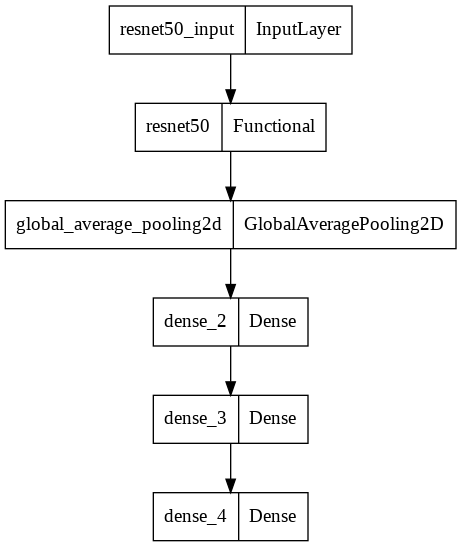

In [ ]:
tf.keras.utils.plot_model(
    resnet50, to_file='./state-farm-distracted-driver-detection/imgs/resnet_model.png'
)

In [ ]:
train_generator, valid_generator = get_train_generator(df_train,df_test, image_dir = None, x_col = "Filename", y_cols = "ClassName", 
                        shuffle=True, batch_size=64, seed=1, target_w = 256, target_h = 256)

Found 17940 validated image filenames.
Found 4484 validated image filenames.


In [82]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 2,
                                            verbose=1,
                                            factor=0.1,
                                            min_lr=0.000001)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

resnet50.compile(optimizer = opt, loss='sparse_categorical_crossentropy', metrics=['accuracy',])

# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# train the network
print("[INFO] training network...")
history = resnet50.fit(train_generator,validation_data = valid_generator, epochs = 7,callbacks=[learning_rate_reduction])

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

[INFO] training network...
Epoch 1/7
281/281 [==============================] - 507s 2s/step - loss: 0.1647 - accuracy: 0.9521 - val_loss: 5.1156 - val_accuracy: 0.0943 - lr: 1.0000e-04
Epoch 2/7
281/281 [==============================] - 493s 2s/step - loss: 0.0176 - accuracy: 0.9948 - val_loss: 2.1102 - val_accuracy: 0.5399 - lr: 1.0000e-04
Epoch 3/7
281/281 [==============================] - 487s 2s/step - loss: 0.0225 - accuracy: 0.9939 - val_loss: 0.0399 - val_accuracy: 0.9886 - lr: 1.0000e-04
Epoch 4/7
281/281 [==============================] - 488s 2s/step - loss: 0.0119 - accuracy: 0.9968 - val_loss: 0.0791 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 5/7
281/281 [==============================] - 484s 2s/step - loss: 0.0233 - accuracy: 0.9933 - val_loss: 0.0324 - val_accuracy: 0.9920 - lr: 1.0000e-04
Epoch 6/7
281/281 [==============================] - 475s 2s/step - loss: 0.0077 - accuracy: 0.9977 - val_loss: 0.3143 - val_accuracy: 0.9643 - lr: 1.0000e-04
Epoch 7/7
281/281 [

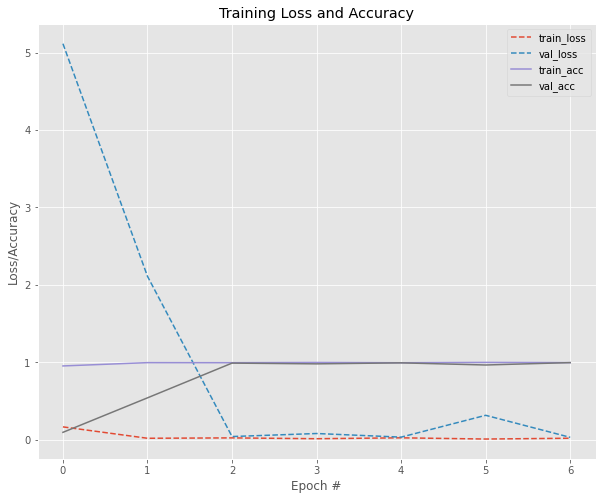

In [83]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 7), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 7), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 7), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 7), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [84]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

[INFO] 0.09873487794682977 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.0045570970551078 kWh
[INFO] Energy consumed for all GPU: 0.053422190006672136 kWh
[INFO] Energy consumed for all CPU: 0.04075559088504978 kWh
[INFO] CO2 emission 0.012736179872663017(in Kg)


In [85]:
# save the model
base_model.save('./state-farm-distracted-driver-detection/model/resnet50_model.h5')